In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
nlp=spacy.load("en_core_web_lg")
pd.set_option("display.max_rows",None)
nltk.download("vader_lexicon")
nltk.download("punkt")
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\25bak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\25bak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [105]:
train=pd.read_csv("Data/train.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [106]:
test=pd.read_csv("Data/test.csv")
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [107]:
print("Null values in training set")
print(train.isnull().sum())
print("Null values in testing set")
print(test.isnull().sum())

Null values in training set
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Null values in testing set
id             0
keyword       26
location    1105
text           0
dtype: int64


In [108]:
print(train[["keyword","text"]].sample(10))

             keyword                                               text
1909         crushed  Disillusioned lead character \nCheck\nHappy go...
5426       panicking  why are people panicking about results day tho...
1564    cliff%20fall  NEWS FLASH!  Any decent billers been promoted ...
5974       screaming  @danisnotonfire if you follow me I will go int...
2351      demolition  Thinking about getting a demo car with a frien...
2177          debris  NBCNightlyNews: Malaysian Officials Say Debris...
392            arson  Trial Date Set for Man Charged with Arson Burg...
7598             NaN  Father-of-three Lost Control of Car After Over...
1006  body%20bagging  Drake Body Bagging Meek. He must of hit a sens...
3780    fire%20truck  wild night in the village of pugwash every fir...


In [109]:
train_real=train[train["target"]==1]
train_fake=train[train["target"]==0]

In [110]:
print(train_real.shape," is the size of real train dataset")
print(train_fake.shape," is the size of fake train dataset")

(3271, 5)  is the size of real train dataset
(4342, 5)  is the size of fake train dataset


In [111]:
print(train_real["keyword"].nunique(),train_fake["keyword"].nunique())
print(test["keyword"].nunique())
print(set(train.keyword.unique())-set(test.keyword.unique()))

220 218
221
set()


In [112]:
impWords=train["keyword"].unique()[:15]
print(impWords)

[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked']


In [113]:
# plt.figure(figsize=(15,10))
# sns.countplot(x=train["keyword"],hue=train["target"])
# plt.xticks(rotation=90)

In [114]:
unique=train["keyword"].unique().astype("str")
unique.tolist()
# uniqueCollection=[unique[i:i+15] 
#                   for i in range(0,len(unique),15)]
# plt.figure(figsize=(10,15))
# subplot_counter=1
# for group in uniqueCollection:
#     plt.figure(figsize=(10,15))
#     plt.subplot(len(uniqueCollection),1,subplot_counter)
#     countplot=sns.countplot(data=train[train["keyword"].isin(group)],x="keyword",hue="target")
#     plt.xticks(rotation=90)
#     plt.legend(title="target",loc="lower left")

['nan',
 'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'derailment',
 'desolat

In [115]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment=SentimentIntensityAnalyzer()

In [116]:
def lastKeyIn(info):
    keyword=info[0]
    text=info[1]
    if pd.notna(keyword):
         return keyword
    doc=nlp(text)
    high_neg=0
    negative_word=None
    for word in doc:
        if word.is_stop or word.is_oov or word.is_space or word.is_punct:
             pass
        elif word.is_ascii:
            if word.text in unique or word.lemma_ in unique:
                return word
            neg=sentiment.polarity_scores(word.text)["neg"]
            if neg>high_neg:
                  high_neg=neg
                  negative_word=word
    if high_neg<0.5:
         return("Others")
    return negative_word.lower

In [117]:
print(train.isnull().sum())
train.keyword=train[["keyword","text"]].apply(lastKeyIn,axis=1)
print(train.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword        0
location    2533
text           0
target         0
dtype: int64


In [118]:
keyword=train.keyword.unique().astype("str")
keyword=keyword.tolist()
keyword=set(keyword)
keyword

{'10595077177392105327',
 '1228720749737493560',
 '13773067740709375554',
 '14012806951969610844',
 '1523267725910686442',
 '7886921362353864828',
 '920492170430266568',
 'CYCLONE',
 'Damage',
 'Earthquake',
 'Evacuation',
 'FIRE',
 'Others',
 'Seismic',
 'Thunderstorm',
 'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'colli

In [119]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,NaN,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [120]:
countries=train.location.unique().tolist()
print(len(countries))

3342


In [121]:
print(countries[1:10])

['Birmingham', 'Est. September 2012 - Bristol', 'AFRICA', 'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!', 'Paranaque City', 'Live On Webcam']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'USA'),
  Text(1, 0, 'New York'),
  Text(2, 0, 'United States'),
  Text(3, 0, 'London'),
  Text(4, 0, 'Canada'),
  Text(5, 0, 'Nigeria'),
  Text(6, 0, 'UK'),
  Text(7, 0, 'Los Angeles, CA'),
  Text(8, 0, 'India'),
  Text(9, 0, 'Mumbai'),
  Text(10, 0, 'Washington, DC'),
  Text(11, 0, 'Kenya'),
  Text(12, 0, 'Worldwide'),
  Text(13, 0, 'Australia'),
  Text(14, 0, 'Chicago, IL')])

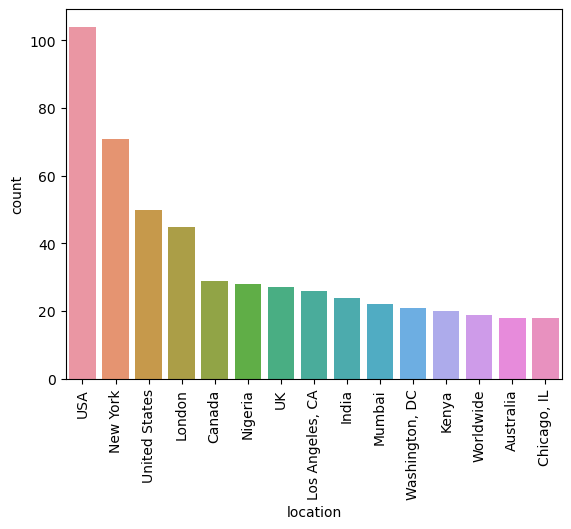

In [122]:
sns.countplot(x=train["location"],order=train.location.value_counts().iloc[:15].index)
plt.xticks(rotation=90)

In [123]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,NaN,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [124]:
text_to_train=train.text[3]

In [125]:
def location(cols):
    location=cols[0]
    text=cols[1]
    if pd.notna(location):
        return location
    text=nlp(text)
    for word in text.ents :
        if word.label_ in ["GPE","LOC"]:
            return word.text
    return "Others"

In [126]:
train["location"]=train[["location","text"]].apply(location,axis=1)

In [127]:
def cleanLocation(x):
    if x == 'Others':
        return 'Others'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    else:
        return x

In [128]:
train["location"]=train["location"].apply(cleanLocation)

In [129]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1


In [130]:
location=train.location.unique().tolist()

In [131]:
len(location)

3026

In [132]:
train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [133]:
# def extractInformation(text):
#     hashWords=[]
#     hash_seq="#(\w+)"
#     hash_count=0
#     text=re.findall(hash_seq,text)
#     for word in text:
#         hash_count+=1  
#         hashWords.append(str(word))
#     return hashWords
# hashtagWords=extractInformation("Hi this is a beatuiful morning #hot #sunny")

In [134]:
def extractInformation(text):
    hash_seq="#(\w+)"
    text=re.findall(hash_seq,text)
    if text==[]:
        return []
    return text
hashtagWords=extractInformation("Hi this is a beatuiful morning hot sunny")

In [135]:
def hashMod(text):
    words=[]
    for word in text:
        if word in keyword:
            words.append(word)
    if words is not []:
        return words
    if text==[]:
        return("None")
    if words is []:
        return text
    

In [136]:
train["HashtagWords"]=train["text"].apply(extractInformation)
train["HashtagWords"]=train["HashtagWords"].apply(hashMod)
train["HashTagSum"]=train["HashtagWords"].apply(lambda x:len(x))

In [137]:
def joinKeywords(text):
    return " ".join(text)
train["HashtagWords"]=train["HashtagWords"].apply(joinKeywords)

In [138]:
# x=train[train["target"]==1]["text"].apply(len)
# y=train[train["target"]==0]["text"].apply(len)
# print("Average length of real tweets are ",np.average(x),"\n Average length of fake tweets are ",np.average(y))

In [139]:
def mentionSearch(text):
    pattern="@(\w+)"
    text=re.findall(pattern,text)
    if text==[]:
        return ("None")
    return " ".join(text)
train["mention"]=train["text"].apply(mentionSearch)
# train["mention"].value_counts()

In [140]:
def sentimentInput(text):
    scores=sentiment.polarity_scores(text)
    return pd.Series([scores["neg"],scores["pos"],scores["neu"],scores["compound"]])
    # train["Negative"]=sentiment.polarity_scores(text)["neg"]
    # train["Neutral"]=sentiment.polarity_scores(text)["neu"]
    # train["Positive"]=sentiment.polarity_scores(text)["pos"]
    # train["Comp"]=sentiment.polarity_scores(text)["compound"]
train[["Negative","Neutral","Positive","Comp"]]=train["text"].apply(sentimentInput)

In [141]:
train.sample(10)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp
2563,3676,destroy,Others,@SarniamakChris @Hromadske @kasiadear33 how s...,1,,0,SarniamakChris Hromadske kasiadear33,0.140,0.140,0.720,-0.2500
6956,9980,tsunami,Others,#sing #tsunami Beginners #computer tutorial.: ...,0,tsunami,1,None,0.000,0.000,1.000,0.0000
2117,3043,death,"Portland, OR",There is this old lady rockin out to death met...,0,,0,None,0.170,0.000,0.830,-0.5994
1564,2258,cliff%20fall,London,NEWS FLASH! Any decent billers been promoted ...,0,,0,None,0.000,0.166,0.834,0.5255
1765,2538,collision,Others,my favorite lady came to our volunteer meeting...,1,,0,None,0.103,0.362,0.535,0.7430
2795,4021,disaster,Mexico,#Metepec #Mexico - ?NIGHT DISASTER?...E(Oficia...,1,,0,None,0.000,0.000,1.000,0.0000
2469,3537,derailment,Chicago,PHOTOS: Green Line derailment near Cottage Gro...,1,,0,None,0.000,0.000,1.000,0.0000
1761,2534,collision,"Denver, Colorado",Motorcyclist bicyclist injured in Denver colli...,1,,0,None,0.426,0.000,0.574,-0.6369
6913,9912,trouble,YA MOTHA BED,@lucysforsale funny cause my dumb ass was the ...,1,,0,lucysforsale,0.359,0.226,0.415,-0.5434
6620,9482,terrorism,Others,Truth...\nhttps://t.co/p5ZIcjUdXO\n#News\n#BBC...,1,terrorism,1,None,0.000,0.000,1.000,0.0000


In [142]:
train.corr()["target"].drop("target")

id            0.060781
HashTagSum    0.075032
Negative      0.124187
Neutral      -0.206829
Positive      0.030898
Comp         -0.220972
Name: target, dtype: float64

In [143]:
# text="You should less drink water and kill more people and stab them"
# scoresSentiment=sentiment.polarity_scores(text)
# scoresSentiment
# sentimentZero=train[train["SentimentScore"]==0]
# sentimentZero['target'].value_counts()
# sentimentNotZero=train[train["SentimentScore"]!=0]
# sentimentNotZero["target"].value_counts()
# sentimentGreaterThan5=(train["SentimentScore"]>0.25).sum()

In [144]:
train["HashtagWords"]=train["HashtagWords"].replace("","None")

In [145]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000,0.149,0.851,0.2732
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286,0.000,0.714,-0.3400
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095,0.000,0.905,-0.2960
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000,0.000,1.000,0.0000
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000,0.000,1.000,0.0000


In [146]:
train["HashtagWords"].unique()

array(['earthquake', 'None', 'wildfires', 'flood disaster', 'flooding',
       'aftershock', 'accident', 'ambulance', 'apocalypse', 'armageddon',
       'bioterrorism', 'bombed', 'wildfire', 'casualties', 'catastrophe',
       'danger', 'dead', 'tragedy crash', 'floods', 'deluge',
       'demolished', 'survived', 'destruction', 'disaster', 'displaced',
       'drought', 'bomb', 'Earthquake', 'fire emergency rescue sirens',
       'evacuate', 'evacuation', 'fire', 'floods flooding', 'hailstorm',
       'hail hailstorm', 'hostages terrorism', 'terrorism', 'hurricane',
       'sinkhole landslide avalanche', 'landslide', 'lava', 'military',
       'disaster mudslide', 'mudslide', 'refugees', 'obliteration',
       'police', 'emergency', 'rainstorm landslide', 'drought wildfires',
       'rescued', 'seismic', 'sinkhole', 'sinking', 'storm', 'thunder',
       'Thunderstorm', 'thunder lightning thunderstorm', 'trauma',
       'survivors', 'traumatised', 'tsunami', 'whirlwind', 'fires',
      

In [147]:
def urlSearch(text):
    pattern=r"https?://t\.co/\S+"
    urls=re.findall(pattern,text)
    if urls:
        return " ".join(urls)
    else:
        return False
    

In [148]:
sample=urlSearch("Hi follow this url https://t.co/7MLMsUzV1Z")
sample

'https://t.co/7MLMsUzV1Z'

In [149]:
train["UrlCount"]=train["text"].apply(urlSearch)

In [150]:
train.sample(10)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp,UrlCount
4695,6675,landslide,Dundee,DUNDEE NEWS: Army veteran fears loose rocks fr...,1,None,0,None,0.412,0.000,0.588,-0.8689,http://t.co/y7Rv0tiL1w
2012,2888,damage,Others,New post on my blog: http://t.co/Avu9b4k2rv \n...,0,None,0,None,0.144,0.000,0.856,-0.4939,http://t.co/Avu9b4k2rv
168,243,airplane%20accident,italy,airplane crashes on house in Colombia 12 peopl...,1,None,0,None,0.412,0.000,0.588,-0.7906,https://t.co/ZhJlfLBHZL
1624,2347,collapse,UK,Now that's what you call a batting collapse #t...,1,None,0,None,0.314,0.000,0.686,-0.4939,False
6515,9317,survive,Kansas,Escaping her captors was the 1st step. Now she...,1,None,0,None,0.206,0.052,0.741,-0.6739,http://t.co/0Q040STkCV
338,485,armageddon,UK,(OFFICIAL VID) &gt; #DoubleCups &gt;&gt; https...,0,None,0,TrubGME THISIZBWRIGHT,0.000,0.000,1.000,0.0000,https://t.co/lfKMTZaEkk
4346,6171,hijack,Nigeria,Tension In Bayelsa As Patience Jonathan Plans ...,1,None,0,None,0.161,0.000,0.839,-0.3182,http://t.co/qxXN6RKsp6 http://t.co/B3X1wqzAoR
114,164,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/M4...,0,None,0,djicemoon,0.000,0.000,1.000,0.0000,http://t.co/M4JDZMGJoW http://t.co/n0uhAsfkBv
3519,5032,eyewitness,Stay Fly?,Lone Survivor: The Eyewitness Account of Opera...,1,None,0,None,0.190,0.250,0.560,0.3400,http://t.co/NXtWXJCAVh http://t.co/oL8ESFRGLE
3327,4766,evacuated,Gold Coast,Powerlines down over tram on GC Highway. Passe...,1,None,0,9NewsBrisbane 9NewsGoldCoast,0.000,0.000,1.000,0.0000,http://t.co/KD3Qsakbi5


In [151]:
def clean_text(text):
    pattern1=r"https?://t\.co/\S+"
    pattern2=r"\d+"
    pattern3=r"@\w+"
    text=re.sub(pattern1,"",text)
    text=re.sub(pattern2,"",text)
    text=re.sub(pattern3,"",text)
    return text.strip()
clean_text("Hi this si a https://t.co/7MLMsUzV1Z 8980098 @return")

'Hi this si a'

In [152]:
train["cleaned_text"]=train["text"].apply(clean_text)

In [153]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp,UrlCount,cleaned_text
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000,0.149,0.851,0.2732,False,Our Deeds are the Reason of this #earthquake M...
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286,0.000,0.714,-0.3400,False,Forest fire near La Ronge Sask. Canada
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095,0.000,0.905,-0.2960,False,All residents asked to 'shelter in place' are ...
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000,0.000,1.000,0.0000,False,", people receive #wildfires evacuation orders ..."
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000,0.000,1.000,0.0000,False,Just got sent this photo from Ruby #Alaska as ...


In [154]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

def grams(text):
    n=3
    text=word_tokenize(text)
    ngramsText=ngrams(text,n)
    return [" ".join(words) for words in ngramsText]

In [155]:
train["Trigrams"]=train["text"].apply(grams)

In [156]:
train.sample(5)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp,UrlCount,cleaned_text,Trigrams
526,761,avalanche,London,Beautiful Sweet Avalanche Faith and Akito rose...,0,None,0,None,0.000,0.447,0.553,0.8658,http://t.co/RaqUpzFkJY http://t.co/quNxocXCgA,Beautiful Sweet Avalanche Faith and Akito rose...,"[Beautiful Sweet Avalanche, Sweet Avalanche Fa..."
4279,6078,heat%20wave,Dallas,Longest Streak of Triple-Digit Heat Since 2013...,1,None,0,None,0.000,0.000,1.000,0.0000,http://t.co/xc96rWUSZb http://t.co/XM9stfzcpV,Longest Streak of Triple-Digit Heat Since For...,"[Longest Streak of, Streak of Triple-Digit, of..."
2307,3311,demolished,Canada,@Flunkie if it makes you feel any better I'm l...,0,None,0,Flunkie,0.000,0.172,0.828,0.4404,False,if it makes you feel any better I'm level and...,"[@ Flunkie if, Flunkie if it, if it makes, it ..."
2907,4175,drown,Where the money at,My parents don't believe in the dream. Sad.,0,None,0,None,0.279,0.180,0.541,-0.2732,False,My parents don't believe in the dream. Sad.,"[My parents do, parents do n't, do n't believe..."
1761,2534,collision,"Denver, Colorado",Motorcyclist bicyclist injured in Denver colli...,1,None,0,None,0.426,0.000,0.574,-0.6369,http://t.co/UpPwxDA4yd,Motorcyclist bicyclist injured in Denver colli...,"[Motorcyclist bicyclist injured, bicyclist inj..."


In [157]:
train["Trigrams"]=train["Trigrams"]

In [158]:
text=train["Trigrams"][0]
text

['Our Deeds are',
 'Deeds are the',
 'are the Reason',
 'the Reason of',
 'Reason of this',
 'of this #',
 'this # earthquake',
 '# earthquake May',
 'earthquake May ALLAH',
 'May ALLAH Forgive',
 'ALLAH Forgive us',
 'Forgive us all']

In [159]:
def vectorize(text):
    vectors=[]
    for trigram in text:
        trigram=nlp(trigram)
        vectors.append(trigram.vector)  
    return vectors      

In [160]:
train.corr()["target"].drop("target").sort_values()

Comp         -0.220972
Neutral      -0.206829
Positive      0.030898
id            0.060781
HashTagSum    0.075032
Negative      0.124187
Name: target, dtype: float64

In [161]:
train.sample(10)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp,UrlCount,cleaned_text,Trigrams
1549,2238,chemical%20emergency,"Evanston, IL",Emergency units simulate a chemical explosion ...,1,None,0,None,0.148,0.000,0.852,-0.3818,http://t.co/ExitLxgIsJ,Emergency units simulate a chemical explosion ...,"[Emergency units simulate, units simulate a, s..."
4326,6145,hijack,Others,0-day bug in fully patched OS X comes under ac...,0,None,0,None,0.073,0.141,0.785,0.3182,http://t.co/F7OgzrNPfv,-day bug in fully patched OS X comes under act...,"[0-day bug in, bug in fully, in fully patched,..."
1201,1727,buildings%20burning,"Madison, GA",@_minimehh @cjoyner I must be overlooking the ...,1,None,0,_minimehh cjoyner,0.000,0.000,1.000,0.0000,False,I must be overlooking the burning buildings? #...,"[@ _minimehh @, _minimehh @ cjoyner, @ cjoyner..."
468,677,attack,US,Police: Assailant in latest US movie theatre a...,1,None,0,None,0.193,0.000,0.807,-0.4767,http://t.co/zdCvlYq6qK,Police: Assailant in latest US movie theatre a...,"[Police : Assailant, : Assailant in, Assailant..."
3413,4884,explode,"Bloomington, IN",After having two cans explode I wanted to drin...,0,None,0,None,0.000,0.000,1.000,0.0000,http://t.co/u6isXv2F3V,After having two cans explode I wanted to drin...,"[After having two, having two cans, two cans e..."
1044,1510,body%20bags,Others,Bitches be takin pics with bags bigger than th...,0,None,0,None,0.306,0.000,0.694,-0.7059,False,Bitches be takin pics with bags bigger than th...,"[Bitches be takin, be takin pics, takin pics w..."
6936,9946,trouble,Manila City,@charlieputh that song have a Cool beat like N...,0,None,0,charlieputh,0.000,0.473,0.527,0.6471,False,that song have a Cool beat like Nothing But Tr...,"[@ charlieputh that, charlieputh that song, th..."
98,141,accident,UK,@flowri were you marinading it or was it an ac...,0,None,0,flowri,0.256,0.000,0.744,-0.4767,False,were you marinading it or was it an accident?,"[@ flowri were, flowri were you, were you mari..."
6061,8660,sinkhole,B&B near Alton Towers,@MoorlandsChmbr Loads of stuff going on recent...,0,sinkhole,1,MoorlandsChmbr,0.000,0.000,1.000,0.0000,http://t.co/XVcO7sLxhW http://t.co/jbVmGeg522,Loads of stuff going on recently. See the blog...,"[@ MoorlandsChmbr Loads, MoorlandsChmbr Loads ..."
78,113,accident,North Carolina,I-77 Mile Marker 31 to 40 South Mooresville I...,1,None,0,None,0.171,0.000,0.829,-0.4767,False,I- Mile Marker to South Mooresville Iredell...,"[I-77 Mile Marker, Mile Marker 31, Marker 31 t..."


In [162]:
text="hello once again i am here to make work happen and once again i would like to thank you al"
def tags(text):
    text=nlp(text)
    for word in text:
        print(word.text ," ",spacy.explain(word.tag_))

In [163]:
def pos(text):
    text=nlp(text)
    oov=0
    noun=0
    adj=0
    adv=0
    verb=0
    punct=0
    det=0
    part=0
    pronoun=0
    conj=0
    prep=0
    interj=0
    num=0
    propernoun=0
    aux=0
    for word in text:
        if word.pos_ == "NOUN":
            noun+=1
        elif word.is_oov:
            oov+=1
        elif word.pos_ == "ADJ":
            adj+=1
        elif word.pos_ == "ADV":
            adv+=1
        elif word.pos_ == "VERB":
            verb+=1
        elif word.pos_ =="PUNCT":
            punct+=1
        elif word.pos_ =="DET":
            det+=1
        elif word.pos_ =="PART":
            part+=1
        elif word.pos_ =="PRON":
            pronoun+=1
        elif word.pos_ =="CONJ":
            conj+=1
        elif word.pos_ =="PREP":
            prep+=1
        elif word.pos_ =="INTERJ":
            interj+=1
        elif word.pos_ =="NUM":
            num+=1
        elif word.pos_ =="PROPN":
            propernoun+=1
        elif word.pos_ =="AUX":
            aux+=1

    return oov,noun,adj,adv,verb,punct,det,part,pronoun,conj,prep,interj,num,propernoun,aux

In [164]:
# oov,noun,adj,adv,verb,punct,det,part,pronoun,conj,prep,interj,num,propernoun,aux=pos(text)

In [165]:
train[["OutOfVocabulary", "Noun", "Adjective", "Adverb", "Verb", "Punctuation", "Deter", "Part","Pronoun","Conjunction","Prepositions","Interjections","NumericalNumbers","ProperN","Auxialry"]]=train["text"].apply(pos).apply(pd.Series)

In [166]:
train.sample(2)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Punctuation,Deter,Part,Pronoun,Conjunction,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry
88,130,accident,"Manchester, NH",Accident left lane blocked in #Manchester on R...,1,None,0,None,0.327,0.0,...,0,0,0,0,0,0,0,2,5,0
3452,4936,exploded,Others,Reasons @BlueWestlo has exploded on @YouTube #...,0,None,0,BlueWestlo YouTube,0.000,0.0,...,1,0,0,0,0,0,0,0,0,1


In [167]:
train["UrlCount"]=train["UrlCount"].apply(lambda x:1 if x!=False else 0)

In [168]:
train.sample(6)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Punctuation,Deter,Part,Pronoun,Conjunction,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry
719,1040,bleeding,IN,you can stab me in the back but I promise you'...,1,None,0,None,0.138,0.170,...,0,2,0,4,0,0,0,1,0,3
3127,4491,electrocuted,Atlanta,Worked in factory pressing designs onto T-shir...,1,None,0,None,0.163,0.000,...,2,0,0,2,0,0,0,0,3,2
4057,5764,forest%20fires,California,A group of Florida Forest Service firefighters...,1,None,0,None,0.000,0.143,...,2,1,1,0,0,0,0,1,4,2
3957,5625,flooding,Jakarta/Kuala Lumpur/S'pore,#Laos flooding -10 villages underwater World V...,1,None,0,None,0.000,0.200,...,0,0,0,1,0,0,0,0,3,0
5970,8523,screaming,New York,@KamKasteIIano @BluntedJayt FUCKING SCREAMING !,0,None,0,KamKasteIIano BluntedJayt,0.608,0.000,...,1,0,0,0,0,0,0,0,0,0
841,1221,blizzard,Others,I really wanna brownie batter blizzard ??,0,None,0,None,0.000,0.000,...,2,0,0,1,0,0,0,0,0,0


In [169]:
train.dtypes

id                    int64
keyword              object
location             object
text                 object
target                int64
HashtagWords         object
HashTagSum            int64
mention              object
Negative            float64
Neutral             float64
Positive            float64
Comp                float64
UrlCount              int64
cleaned_text         object
Trigrams             object
OutOfVocabulary       int64
Noun                  int64
Adjective             int64
Adverb                int64
Verb                  int64
Punctuation           int64
Deter                 int64
Part                  int64
Pronoun               int64
Conjunction           int64
Prepositions          int64
Interjections         int64
NumericalNumbers      int64
ProperN               int64
Auxialry              int64
dtype: object

In [170]:
# def clean_signs(text):
#     text=re.sub(r"[^a-zA-Z\s]","",text)
# train["keyword"]=train["keyword"].astype("str").apply(clean_signs)

<AxesSubplot:xlabel='UrlCount', ylabel='count'>

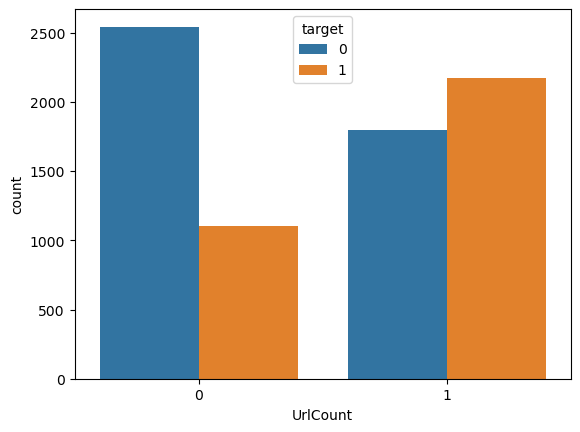

In [171]:
sns.countplot(x="UrlCount",data=train,hue="target")

<AxesSubplot:xlabel='HashTagSum', ylabel='count'>

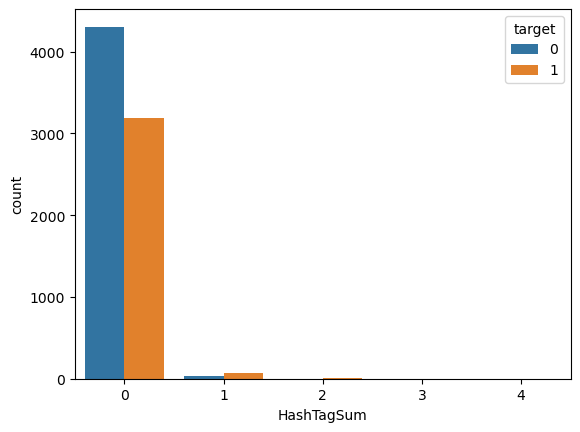

In [172]:
sns.countplot(x="HashTagSum",data=train,hue="target")

In [173]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Punctuation,Deter,Part,Pronoun,Conjunction,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000,0.149,...,0,2,0,3,0,0,0,0,1,2
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286,0.000,...,1,0,0,0,0,0,0,0,5,0
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095,0.000,...,3,2,1,0,0,0,0,0,0,3
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000,0.000,...,0,0,0,0,0,0,0,1,1,0
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000,0.000,...,0,3,0,0,0,0,0,0,3,1


In [174]:
train.corr()["target"].drop("target")

id                  0.060781
HashTagSum          0.075032
Negative            0.124187
Neutral            -0.206829
Positive            0.030898
Comp               -0.220972
UrlCount            0.247134
OutOfVocabulary     0.038573
Noun                0.164720
Adjective           0.038008
Adverb             -0.113162
Verb               -0.047843
Punctuation        -0.038542
Deter              -0.028813
Part               -0.079962
Pronoun            -0.243012
Conjunction              NaN
Prepositions             NaN
Interjections            NaN
NumericalNumbers    0.107651
ProperN             0.124604
Auxialry           -0.118793
Name: target, dtype: float64

In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
normVectorize=TfidfVectorizer(analyzer="word")
trivectorize=TfidfVectorizer(ngram_range=(3,3))
CVectorize=CountVectorizer()

In [176]:
# train["text"]=train["text"].apply(lambda x:x.split())
# train["TextTFIDF"]=list(vectorize.fit_transform(train["text"].values).toarray())
# tfidf=tfidf.toarray()
# train["TextTFIDF"]=list(tfidf)
# train["hashVec"]=list(vectorize.fit_transform(train["HashtagWords"]).toarray())
# hashVec=hashVec.toarray()
# train["hastagWordsVec"]=list(hashVec)

In [177]:
# train.head()

In [178]:
trivectorize=TfidfVectorizer(ngram_range=(3,3))
CVectorize=CountVectorizer()
train["TextTFIDF"]=list(normVectorize.fit_transform(train["text"]).toarray())
train["hashVec"]=list(normVectorize.fit_transform(train["HashtagWords"]).toarray())
train["trigramTFIDF"]=list(trivectorize.fit_transform(train["text"]).toarray())
train["locationVec"]=list(CVectorize.fit_transform(train["location"]).toarray())
train["keyword"]=train["keyword"].astype("str")
train["keywordVec"]=list(CVectorize.fit_transform(train["keyword"]).toarray())
# trigramTFIDFarr=trigramTFIDF.toarray()
# train["TrigramsVec"]=list(trigramTFIDFarr)

In [179]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'HashtagWords',
       'HashTagSum', 'mention', 'Negative', 'Neutral', 'Positive', 'Comp',
       'UrlCount', 'cleaned_text', 'Trigrams', 'OutOfVocabulary', 'Noun',
       'Adjective', 'Adverb', 'Verb', 'Punctuation', 'Deter', 'Part',
       'Pronoun', 'Conjunction', 'Prepositions', 'Interjections',
       'NumericalNumbers', 'ProperN', 'Auxialry', 'TextTFIDF', 'hashVec',
       'trigramTFIDF', 'locationVec', 'keywordVec'],
      dtype='object')

In [180]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry,TextTFIDF,hashVec,trigramTFIDF,locationVec,keywordVec
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000,0.149,...,0,0,0,1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286,0.000,...,0,0,0,5,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095,0.000,...,0,0,0,0,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000,0.000,...,0,0,1,1,0,"[0.0, 0.41744665140268544, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000,0.000,...,0,0,0,3,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [181]:
locDataFrame=pd.DataFrame(train["location"])

In [182]:
locDataFrame.to_csv("LocValues.csv")

In [183]:
train.corr()["target"]

id                  0.060781
target              1.000000
HashTagSum          0.075032
Negative            0.124187
Neutral            -0.206829
Positive            0.030898
Comp               -0.220972
UrlCount            0.247134
OutOfVocabulary     0.038573
Noun                0.164720
Adjective           0.038008
Adverb             -0.113162
Verb               -0.047843
Punctuation        -0.038542
Deter              -0.028813
Part               -0.079962
Pronoun            -0.243012
Conjunction              NaN
Prepositions             NaN
Interjections            NaN
NumericalNumbers    0.107651
ProperN             0.124604
Auxialry           -0.118793
Name: target, dtype: float64

In [184]:
train.sample(2)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry,TextTFIDF,hashVec,trigramTFIDF,locationVec,keywordVec
5087,7254,nuclear%20disaster,New York,Physical sense helps preserve memories of 2011...,1,None,0,None,0.208,0.132,...,0,0,2,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2251,3222,deluged,Others,Businesses are deluged with invokces. Make you...,0,None,0,None,0.056,0.071,...,0,0,0,0,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [185]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'HashtagWords',
       'HashTagSum', 'mention', 'Negative', 'Neutral', 'Positive', 'Comp',
       'UrlCount', 'cleaned_text', 'Trigrams', 'OutOfVocabulary', 'Noun',
       'Adjective', 'Adverb', 'Verb', 'Punctuation', 'Deter', 'Part',
       'Pronoun', 'Conjunction', 'Prepositions', 'Interjections',
       'NumericalNumbers', 'ProperN', 'Auxialry', 'TextTFIDF', 'hashVec',
       'trigramTFIDF', 'locationVec', 'keywordVec'],
      dtype='object')

In [186]:
train.dtypes

id                    int64
keyword              object
location             object
text                 object
target                int64
HashtagWords         object
HashTagSum            int64
mention              object
Negative            float64
Neutral             float64
Positive            float64
Comp                float64
UrlCount              int64
cleaned_text         object
Trigrams             object
OutOfVocabulary       int64
Noun                  int64
Adjective             int64
Adverb                int64
Verb                  int64
Punctuation           int64
Deter                 int64
Part                  int64
Pronoun               int64
Conjunction           int64
Prepositions          int64
Interjections         int64
NumericalNumbers      int64
ProperN               int64
Auxialry              int64
TextTFIDF            object
hashVec              object
trigramTFIDF         object
locationVec          object
keywordVec           object
dtype: object

In [204]:
train[["keyword", "location", "HashtagWords", "mention"]] = train[["keyword", "location", "HashtagWords", "mention"]].astype("str")


In [210]:
train.dtypes

id                    int64
keyword              object
location             object
text                 object
target                int64
HashtagWords         object
HashTagSum            int64
mention              object
Negative            float64
Neutral             float64
Positive            float64
Comp                float64
UrlCount              int64
cleaned_text         object
Trigrams             object
OutOfVocabulary       int64
Noun                  int64
Adjective             int64
Adverb                int64
Verb                  int64
Punctuation           int64
Deter                 int64
Part                  int64
Pronoun               int64
Conjunction           int64
Prepositions          int64
Interjections         int64
NumericalNumbers      int64
ProperN               int64
Auxialry              int64
TextTFIDF            object
hashVec              object
trigramTFIDF         object
locationVec          object
keywordVec           object
dtype: object

In [226]:
train.sample(8)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry,TextTFIDF,hashVec,trigramTFIDF,locationVec,keywordVec
5373,7669,panic,"Philadelphia, PA",Despite the crippling anxiety and overwhelming...,0,None,0,None,0.350,0.086,...,0,0,0,0,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5167,7369,obliterate,UK,Know them recognize them......then obliterate ...,0,None,0,None,0.276,0.000,...,0,0,0,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1150,1657,bombing,Hiroshima,@snapharmony : Bells toll in Hiroshima as Japa...,1,None,0,snapharmony,0.000,0.000,...,0,0,1,2,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1109,1602,bombed,Others,@BrodyFrieling @hanna_brooksie photo bombed,0,None,0,BrodyFrieling hanna_brooksie,0.000,0.000,...,0,0,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6488,9276,sunk,New York,Aquarium Ornament Wreck Sailing Boat Sunk Ship...,1,None,0,None,0.282,0.000,...,0,0,0,8,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4523,6427,hurricane,Others,#kick #hurricane Seriously #simple websites: h...,1,hurricane,1,None,0.236,0.000,...,0,0,0,2,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3733,5305,fear,Halifax,The number of people denying climate change on...,0,None,0,None,0.136,0.041,...,0,0,0,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4655,6619,inundated,Toronto,inundated with Westeros Between Storm of Sword...,0,None,0,None,0.000,0.000,...,0,0,0,6,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [230]:
x=train.drop(columns="target")
y=train["target"]

In [233]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
normVectorizePipeline=Pipeline([
    ("normVectorizer",CountVectorizer())
])
TrigramVectorizePipeline=Pipeline([
    ("trigramVectorizer",TfidfVectorizer(ngram_range=(3,3)))
])
scaler=Pipeline([
    ("scale",StandardScaler())
])
normList=["keyword","location"]
scaleList=['OutOfVocabulary', 'Noun','Adjective', 'Adverb', 'Verb', 'Punctuation', 'Deter', 'Part',
       'Pronoun', 'Conjunction', 'Prepositions', 'Interjections','NumericalNumbers', 'ProperN', 'Auxialry']
preprocessor=ColumnTransformer(
    transformers=[
        ("norm",normVectorizePipeline,"keyword"),
        ("norm1",normVectorizePipeline,"location"),
        ("norm2",normVectorizePipeline,"HashtagWords"),
        ("norm3",normVectorizePipeline,"mention"),
        ("trigram",TrigramVectorizePipeline,"text"),
        ("scale",scaler,scaleList)
    ]
)
pipeline=Pipeline([
    ("finalPipeline",preprocessor)
])
X=pipeline.fit_transform(x)

In [242]:
X=X.toarray()

In [243]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.25)

In [244]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
model=GaussianNB()
model.fit(x_train,y_train)
y_pred=model.predict(x_train)
print(classification_report(y_pred,y_test))

ValueError: Found input variables with inconsistent numbers of samples: [5709, 1904]